In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"

import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
from jax.experimental.sparse import COO
from nrmifactors import algorithm as algo
from nrmifactors.state import State
import nrmifactors.priors as priors
import pickle

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

key = random.PRNGKey(0)

In [2]:
from nrmifactors.algorithm import update_tau_gmrf, update_lambda_gmrf

In [3]:
with open("income_data/california_puma_neighbors.pickle", "rb") as fp:
    neighbors = pickle.load(fp)

In [4]:
prec = np.diag(neighbors.sum(axis=1)) - neighbors
eigvals, eigvecs = np.linalg.eigh(prec)
prec_logdet = np.sum(np.log(eigvals[eigvals > 1e-6]))
prec = COO.fromdense(prec)

In [5]:
nlat = 10
true_tau = 5

fake_prec = true_tau * (np.diag(neighbors.sum(axis=1)) - 0.95 * neighbors)
cov = np.linalg.inv(fake_prec)

log_lam = tfd.MultivariateNormalFullCovariance(
    np.zeros(cov.shape[0]), cov).sample(sample_shape=(nlat,), seed=key).T
lam = np.exp(log_lam)

In [6]:
lam.shape

(265, 10)

In [7]:
natoms = 10
ndata = 500
ngr = lam.shape[0]
m = np.ones((nlat, natoms))
j = np.ones(natoms)

weights = (lam @ m) * j
u = tfd.Gamma(np.ones(ngr) * ndata, np.sum(weights, axis=1)).sample(seed=key)
weights = weights / np.sum(weights, axis=1).reshape(-1, 1)

In [8]:
clus_allocs = tfd.Categorical(probs=weights).sample(sample_shape=(500,), seed=key).T

In [9]:
mcmc_lam = np.ones(lam.shape) * 20
lam_chain = []

for i in range(100):
    print("\r{0}/{1}".format(i+1, 1000), flush=True, end=" ")
    mcmc_lam, key, step_size = update_lambda_gmrf(
        clus_allocs, mcmc_lam, m, j, u, prec, prec_logdet, true_tau, key)
    lam_chain.append(mcmc_lam)

100/1000 

In [10]:
def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    print(dens.shape)
    dens = np.sum(dens, axis=-1).T
    return dens

(1000, 265, 10)
(1000, 265, 10)
(1000, 265, 10)
(1000, 265, 10)


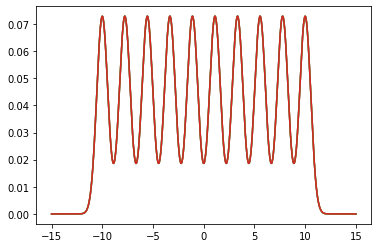

In [11]:
xgrid = np.linspace(-15, 15, 1000)
atoms = np.hstack([np.linspace(-10, 10, 10).reshape(-1, 1), np.ones(10).reshape(-1, 1) * 0.3])
true_dens = eval_densities(xgrid, lam, m, j, atoms)
plt.plot(xgrid, true_dens[0, :])

for i in [-50, -5, -1]:
    est_dens = eval_densities(xgrid, lam_chain[i], m, j, atoms)  
    plt.plot(xgrid, est_dens[0, :])

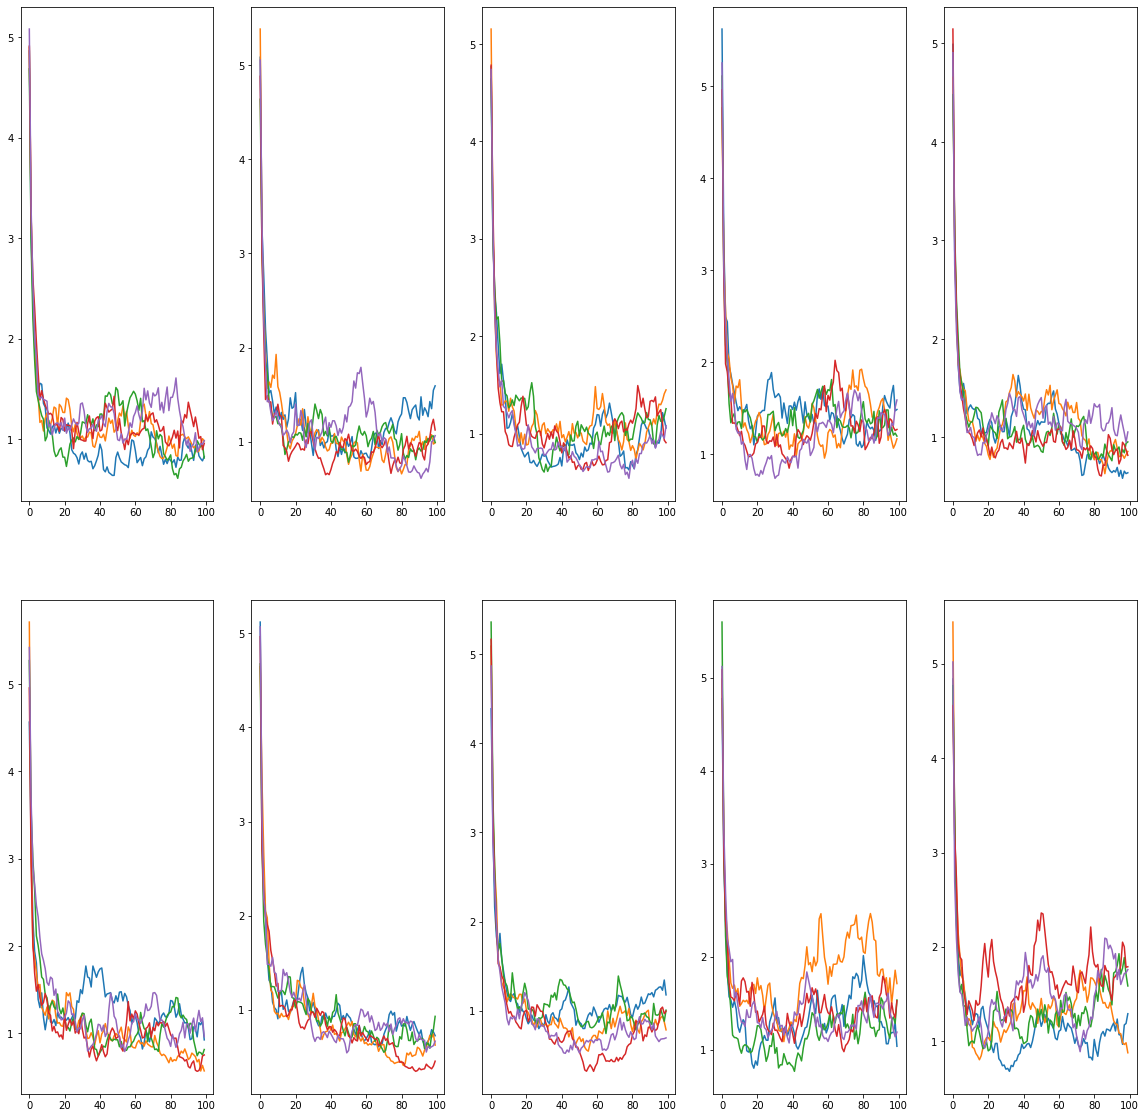

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 20))
axes = axes.flat

for j in range(nlat):
    for i in range(5):
        axes[j].plot([x[i, j] for x in lam_chain])